In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
train_df = pd.read_csv('train.csv', index_col=['id'])
test_df = pd.read_csv('test.csv', index_col=['id'])
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
train_df.tail()

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
64315,2018-05-01 22:45:00,12.458,1.407,7.889,-0.746,4.843,1.523,10.622
64316,2018-05-01 23:00:00,14.200,1.541,9.310,0.284,4.752,1.249,10.482
64317,2018-05-01 23:15:00,12.659,1.474,7.924,-0.959,4.569,1.310,10.271
64318,2018-05-01 23:30:00,13.329,1.541,8.671,-0.533,4.630,1.371,10.341
64319,2018-05-01 23:45:00,11.588,0.871,7.214,-0.426,4.691,1.310,10.833


<Figure size 1200x600 with 0 Axes>

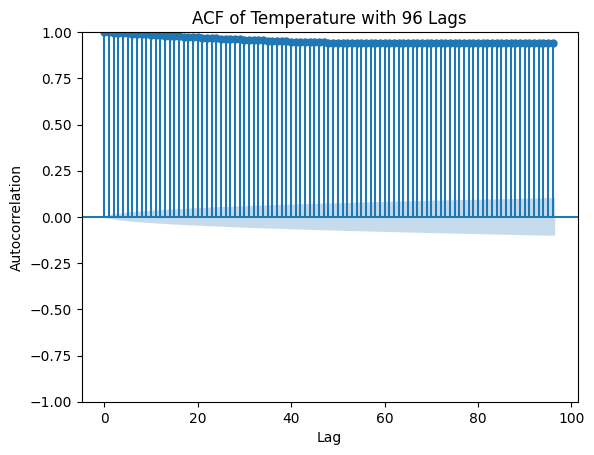

In [92]:
# Plot the ACF chart for the temperature
plt.figure(figsize=(12, 6))
plot_acf(train_df['Temperature'], lags=96)
plt.title('ACF of Temperature with 96 Lags')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [4]:
def simple_preprocess(df):
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['doy'] = df['date'].dt.day_of_year
    df['minute'] = df['date'].dt.minute

    return df

In [5]:
train_df = simple_preprocess(train_df)
test_df = simple_preprocess(test_df)

In [6]:
def add_cosine_sine_features(dataframe, column_name):
    """
    Adds cosine and sine features for a given cyclical column.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the cyclical column (e.g., 'hour').

    Returns:
    pd.DataFrame: The DataFrame with added cosine and sine features.
    """
    dataframe[f'{column_name}_cos'] = np.cos(2 * np.pi * dataframe[column_name] / 24)
    dataframe[f'{column_name}_sin'] = np.sin(2 * np.pi * dataframe[column_name] / 24)
    return dataframe



In [7]:
train_df=add_cosine_sine_features(train_df, 'month')

In [8]:
test_df=add_cosine_sine_features(test_df, 'month')

In [9]:
train_df.tail()

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature,hour,month,doy,minute,month_cos,month_sin
id,,,,,,,,,,,,,,
64315,2018-05-01 22:45:00,12.458,1.407,7.889,-0.746,4.843,1.523,10.622,22,5,121,45,0.258819,0.965926
64316,2018-05-01 23:00:00,14.200,1.541,9.310,0.284,4.752,1.249,10.482,23,5,121,0,0.258819,0.965926
64317,2018-05-01 23:15:00,12.659,1.474,7.924,-0.959,4.569,1.310,10.271,23,5,121,15,0.258819,0.965926
64318,2018-05-01 23:30:00,13.329,1.541,8.671,-0.533,4.630,1.371,10.341,23,5,121,30,0.258819,0.965926
64319,2018-05-01 23:45:00,11.588,0.871,7.214,-0.426,4.691,1.310,10.833,23,5,121,45,0.258819,0.965926


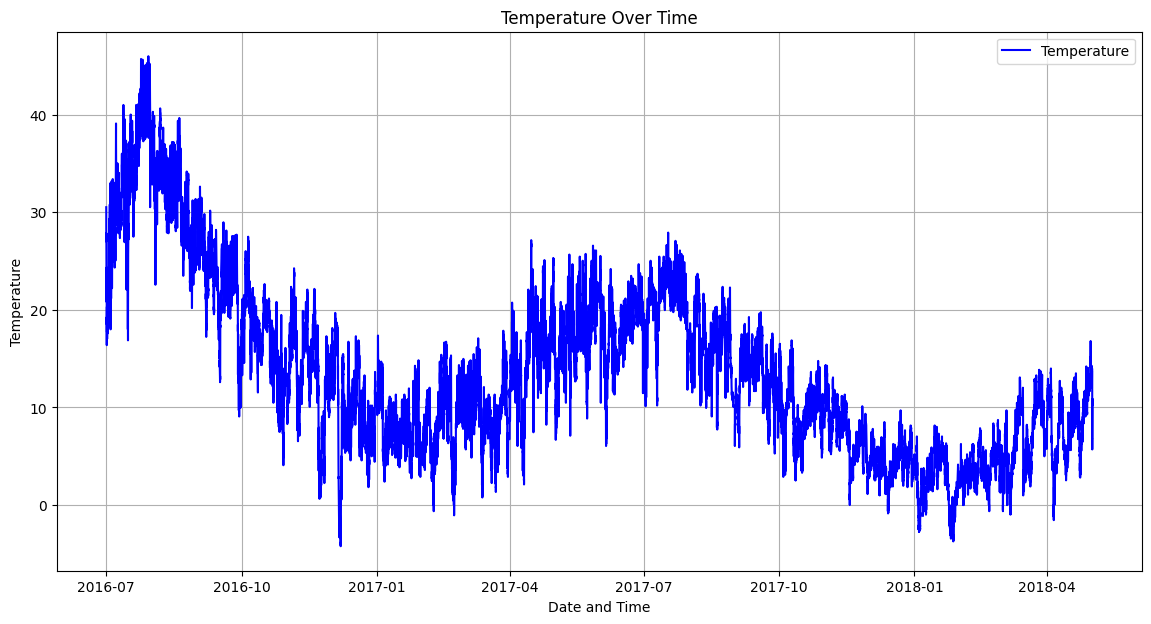

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(train_df['date'], train_df['Temperature'], label='Temperature', color='blue')
plt.xlabel('Date and Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

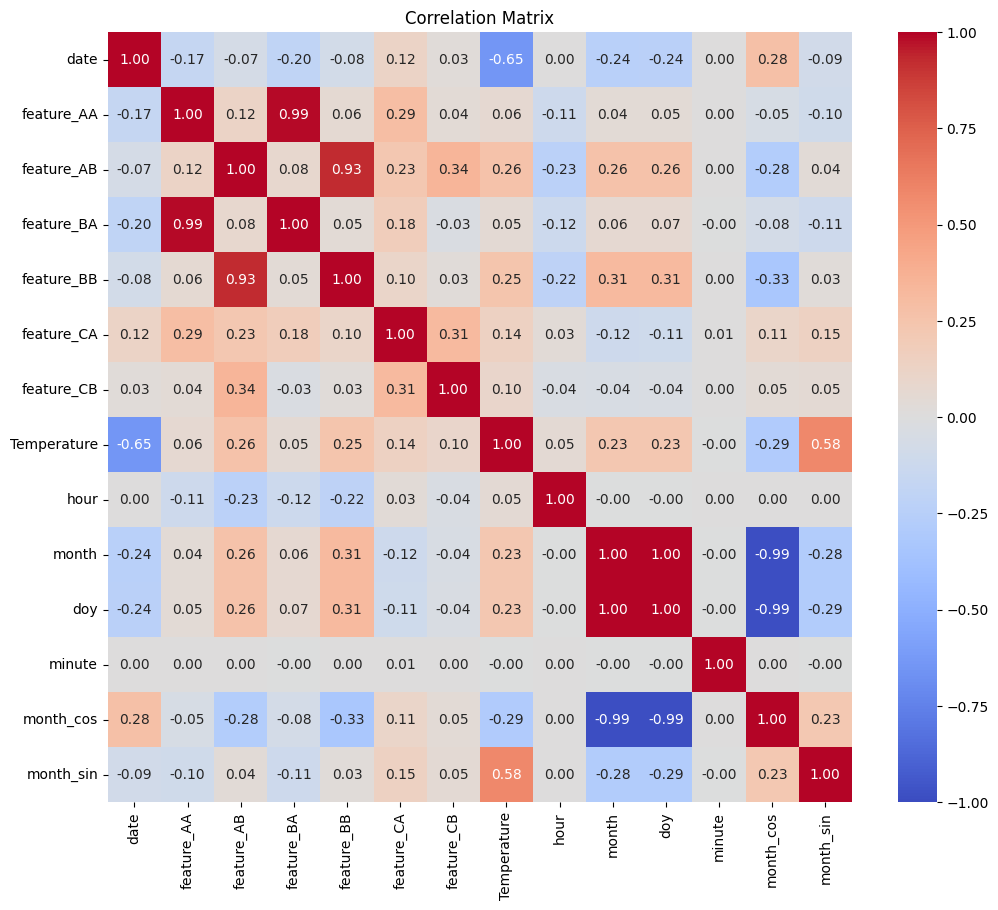

In [11]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [12]:
#drop date columns
train_df = train_df.drop(columns=['date'])
test_df = test_df.drop(columns=['date'])

In [13]:

train_df.columns

Index(['feature_AA', 'feature_AB', 'feature_BA', 'feature_BB', 'feature_CA',
       'feature_CB', 'Temperature', 'hour', 'month', 'doy', 'minute',
       'month_cos', 'month_sin'],
      dtype='object')

In [14]:
test_df.columns

Index(['feature_AA', 'feature_AB', 'feature_BA', 'feature_BB', 'feature_CA',
       'feature_CB', 'hour', 'month', 'doy', 'minute', 'month_cos',
       'month_sin'],
      dtype='object')

### ***Apply Exponential Smoothing***


In [15]:
endog = train_df['Temperature']

es_model = ExponentialSmoothing(endog, trend='add', seasonal='add', seasonal_periods=12)
es_fit = es_model.fit(optimized=True)

In [16]:
# Predict the Temperature for the next 5360 records using Exponential Smoothing
es_forecast = es_fit.forecast(steps=5360)
es_forecast_list = es_forecast.tolist()

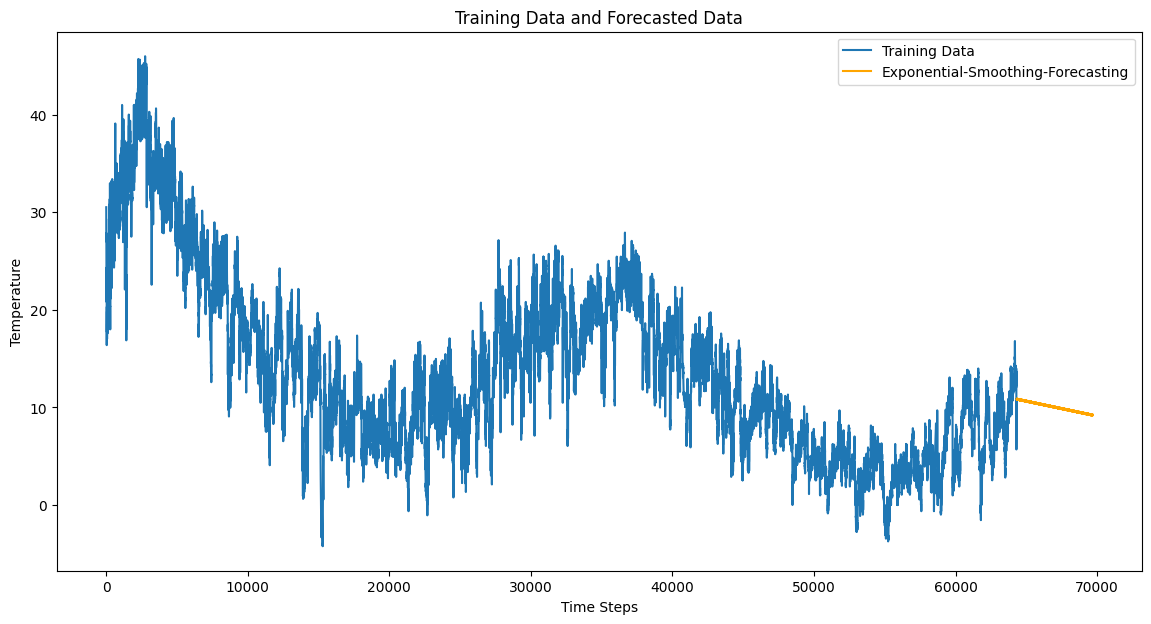

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(train_df)), train_df['Temperature'], label='Training Data')
plt.plot(np.arange(len(train_df), len(train_df) + len(es_forecast_list)), es_forecast_list, label='Exponential-Smoothing-Forecasting', color='orange')

# Add titles and labels
plt.title('Training Data and Forecasted Data')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()

# Display the plot
plt.show()

In [18]:
# Step 2: Compute residuals from Exponential Smoothing forecasts
train_predictions_es = es_fit.fittedvalues
train_residuals = endog - train_predictions_es

In [26]:
# Step 3: Fit an ARIMA model to the residuals
# Example parameters for ARIMA, adjust based on your data
arima_model = ARIMA(train_residuals, order=(9, 1, 0))
arima_fit = arima_model.fit()

In [27]:
# Step 4: Forecast the residuals using the ARIMA model
arima_forecast = arima_fit.forecast(steps=5360)

In [28]:
# Step 5: Combine the forecasts
final_forecast = es_forecast + arima_forecast

In [35]:
test_df['Temperature'] = final_forecast

In [36]:
train_df.shape

(64320, 13)

In [38]:
test_df.shape

(5360, 13)

In [39]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Check the combined data frame
print(combined_df.shape) 

(69680, 13)


In [40]:
def create_lag_features(df, column, lags):
    for lag in lags:
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

In [41]:
lags = list(range(1, 97))  # Create a list from 1 to 96
combined_df = create_lag_features(combined_df, 'Temperature', lags)

C:\Windows\Temp\ipykernel_6532\3773238980.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag{lag}'] = df[column].shift(lag)
C:\Windows\Temp\ipykernel_6532\3773238980.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag{lag}'] = df[column].shift(lag)
C:\Windows\Temp\ipykernel_6532\3773238980.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

In [42]:
combined_df.shape

(69680, 109)

In [43]:
test_df = combined_df.tail(5360).copy()

In [44]:
train_df = combined_df.head(64320).copy()

### ***Developing a LGBM model and checking its performance on validation data***

In [50]:
train_df.fillna(0, inplace=True)

In [52]:
X = train_df.drop(columns=['Temperature'])
y = train_df['Temperature'].copy()

In [54]:
from sklearn.model_selection import train_test_split, KFold

In [55]:
# make it time-based-like, no shuffle
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False)

# CV loop for expected value predictions and absolute errors
inputs, predictions, targets, abs_errors = [], [], [], []
cv = KFold(5, shuffle=False)

for CV_train, CV_valid in cv.split(X_train):
    X_CV_train, y_CV_train = X_train.iloc[CV_train], y_train[CV_train]
    X_CV_valid, y_CV_valid = X_train.iloc[CV_valid], y_train[CV_valid]

    model = LGBMRegressor(objective='quantile', alpha=0.5, verbose=-1)
    model.fit(X_CV_train, y_CV_train)
    
    y_pred_CV_valid = model.predict(X_CV_valid)
    
    abs_error = abs(y_CV_valid - y_pred_CV_valid)
    
    inputs.append(X_CV_valid)
    predictions.append(y_pred_CV_valid)
    abs_errors.append(abs_error)
    targets.append(y_CV_valid)

# fit full median model
median_model = LGBMRegressor(objective='quantile', alpha=0.5, verbose=-1)
median_model.fit(X_train, y_train)
    
# get DLE inputs
DLE_inputs = pd.concat(inputs)
DLE_inputs['medina_model_pred'] = np.concatenate(predictions)
DLE_target = np.concatenate(abs_errors)
CV_targets = np.concatenate(targets)

In [56]:
DLE_inputs.columns


Index(['feature_AA', 'feature_AB', 'feature_BA', 'feature_BB', 'feature_CA',
       'feature_CB', 'hour', 'month', 'doy', 'minute',
       ...
       'Temperature_lag88', 'Temperature_lag89', 'Temperature_lag90',
       'Temperature_lag91', 'Temperature_lag92', 'Temperature_lag93',
       'Temperature_lag94', 'Temperature_lag95', 'Temperature_lag96',
       'medina_model_pred'],
      dtype='object', length=109)

In [68]:
len(X_valid)

19296

In [58]:
len(CV_targets)

45024

In [59]:
quantiles = submission_df.columns.to_list()[1:]
coverage_and_quantile_dic = {}
for left, right in zip(quantiles, reversed(quantiles)):
    coverage = np.round(float(right)-float(left), 2)
    if coverage > 0:
        coverage_and_quantile_dic[coverage] = left, right
coverage_and_quantile_dic

{0.95: ('0.025', '0.975'),
 0.9: ('0.05', '0.95'),
 0.8: ('0.10', '0.90'),
 0.7: ('0.15', '0.85'),
 0.6: ('0.20', '0.80'),
 0.5: ('0.25', '0.75'),
 0.4: ('0.30', '0.70'),
 0.3: ('0.35', '0.65'),
 0.2: ('0.40', '0.60'),
 0.1: ('0.45', '0.55')}

In [60]:
coverage_models = {}
for required_coverage in coverage_and_quantile_dic.keys():
    model = LGBMRegressor(objective='quantile', alpha=required_coverage, verbose=-1)
    model = model.fit(DLE_inputs, DLE_target)
    coverage_models[required_coverage] = model

In [61]:
coverage_models

{0.95: LGBMRegressor(alpha=0.95, objective='quantile', verbose=-1),
 0.9: LGBMRegressor(alpha=0.9, objective='quantile', verbose=-1),
 0.8: LGBMRegressor(alpha=0.8, objective='quantile', verbose=-1),
 0.7: LGBMRegressor(alpha=0.7, objective='quantile', verbose=-1),
 0.6: LGBMRegressor(alpha=0.6, objective='quantile', verbose=-1),
 0.5: LGBMRegressor(alpha=0.5, objective='quantile', verbose=-1),
 0.4: LGBMRegressor(alpha=0.4, objective='quantile', verbose=-1),
 0.3: LGBMRegressor(alpha=0.3, objective='quantile', verbose=-1),
 0.2: LGBMRegressor(alpha=0.2, objective='quantile', verbose=-1),
 0.1: LGBMRegressor(alpha=0.1, objective='quantile', verbose=-1)}

In [62]:
median_model_test_pred = median_model.predict(X_valid)
X_valid['median_model_pred'] = median_model_test_pred

In [63]:
valid_submission = pd.DataFrame(columns=submission_df.columns[1:])

valid_submission['0.50'] = median_model_test_pred

for coverage, quantiles in coverage_and_quantile_dic.items():
    abs_error_prediction_for_coverage = coverage_models[coverage].predict(X_valid)
    lower = median_model_test_pred - abs_error_prediction_for_coverage
    upper = median_model_test_pred + abs_error_prediction_for_coverage
    
    left_quantile, right_quantile = quantiles
    
    valid_submission[left_quantile] = lower
    valid_submission[right_quantile] = upper

In [64]:
def crps(submission, solution):
    """
    This routine returns the mean continuous ranked probability score (CRPS).
    Each individual CRPS score is numerically integrated using 23 points.
    The extremal points (100% coverage) are competition fixed at -30 and 60.
    The "submission" dataframe: the last 21 columns should be the predictions
    The "solution" dataframe must contain a "Temperature" column (the "ground truth")
    
    Author: Carl McBride Ellis
    Version: 1.0.0
    Date: 2024-03-30
    """
        
    # A list of the requested quantile values, along with added 100% coverage endpoints 
    # (these values are all competition fixed)
    # the 0.5 quantile is the "zero coverage" forecast i.e. the median point prediction
    quantiles = [0.00, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 1.00]
    submission_tmp = submission.copy()
    # inset the y_true values to the submission_tmp dataframe to the LHS
    submission_tmp.insert(0, "Temperature", solution["Temperature"].values)
    
    CRPS = 0
    for index, row in submission_tmp.iterrows():
        x_values = row[-(len(quantiles)-2):] # column name agnostic
        y_true = row["Temperature"] # the ground truth value
        
        x_values = [float(i) for i in x_values] # make sure all x values are floats
        # add extremal 100% quantile x-values so as to be sure to bracket all possible y_true values
        # note: any changing of these values will change the score
        x_values.append(-30.0)
        x_values.append( 60.0)
        x_values.sort() # sort x values into ascending order (no quantile crossing)

        # split predictions to the left and right of the true value
        # get items below the true value (y_true)
        LHS_keys = [i for i,x in enumerate(x_values) if x < y_true]
        # get items above the true value (y_true)
        RHS_keys = [i for i,x in enumerate(x_values) if x >= y_true]

        # quantiles and predictions below the true value (y_true)
        LHS_values = [x_values[i] for i in LHS_keys]
        LHS_quantiles = [quantiles[i] for i in LHS_keys]

        # quantiles and predictions above the true value (y_true)
        RHS_values = [x_values[i] for i in RHS_keys]
        RHS_quantiles = [quantiles[i] for i in RHS_keys]

        # also calculate quantile at y (q_at_y_true)
        x1, y1 = LHS_values[-1], LHS_quantiles[-1]
        x2, y2 = RHS_values[0], RHS_quantiles[0]
        q_at_y_true = ((y2-y1)*(y_true-x1)/(x2-x1))+y1

        # add y_true and q_at_y_true to RHS of LHS list
        LHS_values.append(y_true)
        LHS_quantiles.append(q_at_y_true)

        # add y_true and q_at_y_true to LHS of RHS list
        RHS_values.insert(0, y_true)
        RHS_quantiles.insert(0, q_at_y_true)

        # integrate the LHS as a sum of trapezium for CDF**2
        LHS_integral = 0
        for i in range(len(LHS_values)-1):
            LHS_integral += (0.5 * (LHS_values[i+1]-LHS_values[i]) * (LHS_quantiles[i]**2 + LHS_quantiles[i+1]**2) )

        # integrate the RHS as a sum of trapezium for (1-CDF)**2
        RHS_integral = 0
        for i in range(len(RHS_values)-1):
            RHS_integral += (0.5 * (RHS_values[i+1]-RHS_values[i]) * ((1-RHS_quantiles[i])**2 +(1-RHS_quantiles[i+1])**2 ) )

        CRPS += (LHS_integral + RHS_integral)

    del submission_tmp
    # calculate the mean CRPS
    CRPS = CRPS/len(submission)
    return CRPS

def coverage_report(submission, solution):
    """
    Version: 1.0.1
    """
    y_true = solution["Temperature"].values
    # this does not take the "zero coverage" prediction into account
    # which is assumed to be located in submission.csv column -11
    coverages = [95, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    N = len(coverages)
    # ANSI color codes
    BOLD_RED = '\033[1;31m'
    BOLD_GREEN = '\033[1;32m'
    END_COLOR = '\033[0m'
    
    def mean_coverage(y_pred_low,y_true,y_pred_up):
        return ( (y_pred_low <= y_true) & (y_pred_up >= y_true) ).mean()
    
    for i, coverage in enumerate(coverages):
        lower_col, upper_col = (2*N+1-i), (i+1)
        actual_coverage = mean_coverage(submission.iloc[:,-lower_col], y_true, submission.iloc[:,-upper_col])
        actual_coverage = round(actual_coverage*100,2)
        if actual_coverage >= coverages[i]:
            print(BOLD_GREEN, "Ideal: {}% Actual: {}% [PASS]".format(coverage, actual_coverage), END_COLOR)
        else:
            print(BOLD_RED, "Ideal: {}% Actual: {}% [FAIL]".format(coverage, actual_coverage), END_COLOR)

In [66]:
crps_score = crps(valid_submission, pd.DataFrame(y_valid).reset_index(drop=True))
crps_score

0.25934600174955524

In [73]:
report=coverage_report(valid_submission, pd.DataFrame(y_valid).reset_index(drop=True))
report

 Ideal: 95% Actual: 99.01% [PASS] 
 Ideal: 90% Actual: 97.68% [PASS] 
 Ideal: 80% Actual: 94.11% [PASS] 
 Ideal: 70% Actual: 89.67% [PASS] 
 Ideal: 60% Actual: 83.19% [PASS] 
 Ideal: 50% Actual: 74.33% [PASS] 
 Ideal: 40% Actual: 64.57% [PASS] 
 Ideal: 30% Actual: 52.29% [PASS] 
 Ideal: 20% Actual: 38.28% [PASS] 
 Ideal: 10% Actual: 20.1% [PASS] 


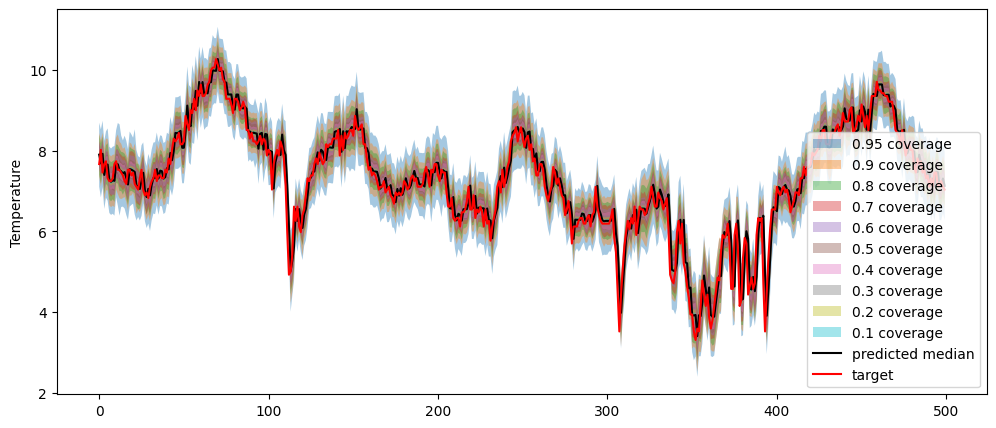

In [72]:
plot_observations = 500
to_plot = valid_submission.iloc[:plot_observations]
plt.figure(figsize=(12,5))

for coverage, quantiles in coverage_and_quantile_dic.items():
    left, right = quantiles
    plt.fill_between(x=to_plot.index, y1 = to_plot[left], y2 = to_plot[right], label=f'{coverage} coverage', alpha=0.4)
    
plt.plot(to_plot['0.50'], color='black', label='predicted median')
plt.plot(y_valid.iloc[:plot_observations].values, label='target', color='red')
plt.ylabel('Temperature')
plt.legend();

### ***Training the LightGBMmodel on entire dataset***

In [74]:
# CV loop for expected value predictions and absolute errors
inputs, predictions, targets, abs_errors = [], [], [], []
cv = KFold(5, shuffle=False)

for CV_train, CV_valid in cv.split(X):
    X_CV_train, y_CV_train = X.iloc[CV_train], y[CV_train]
    X_CV_valid, y_CV_valid = X.iloc[CV_valid], y[CV_valid]

    model = LGBMRegressor(objective='quantile', alpha=0.5, verbose=-1)
    model.fit(X_CV_train, y_CV_train)
    
    y_pred_CV_valid = model.predict(X_CV_valid)
    
    abs_error = abs(y_CV_valid - y_pred_CV_valid)
    
    inputs.append(X_CV_valid)
    predictions.append(y_pred_CV_valid)
    abs_errors.append(abs_error)
    targets.append(y_CV_valid)

# fit full median model
median_model = LGBMRegressor(objective='quantile', alpha=0.5, verbose=-1)
median_model.fit(X, y)
    
# get DLE inputs
DLE_inputs = pd.concat(inputs)
DLE_inputs['medina_model_pred'] = np.concatenate(predictions)
DLE_target = np.concatenate(abs_errors)
CV_targets = np.concatenate(targets)

In [75]:
coverage_models = {}
for required_coverage in coverage_and_quantile_dic.keys():
    model = LGBMRegressor(objective='quantile', alpha=required_coverage, verbose=-1)
    model = model.fit(DLE_inputs, DLE_target)
    coverage_models[required_coverage] = model

In [79]:
test_df=test_df.drop(columns=['Temperature'])

In [80]:
median_model_test_pred = median_model.predict(test_df)
test_df['Temperature'] = median_model_test_pred

### ***forecasting final temperature and quantiles***

In [81]:
test_submission = pd.DataFrame(columns=submission_df.columns[1:])

test_submission['0.50'] = median_model_test_pred

for coverage, quantiles in coverage_and_quantile_dic.items():
    abs_error_prediction_for_coverage = coverage_models[coverage].predict(test_df)
    lower = median_model_test_pred - abs_error_prediction_for_coverage
    upper = median_model_test_pred + abs_error_prediction_for_coverage
    
    left_quantile, right_quantile = quantiles
    
    test_submission[left_quantile] = lower
    test_submission[right_quantile] = upper

In [96]:
test_submission.head()

,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975
0,10.188801,10.428602,10.508868,10.633646,10.724041,10.803449,10.844985,10.881404,10.936651,10.981034,...,11.051879,11.096263,11.151509,11.187928,11.229464,11.308872,11.399267,11.524046,11.604312,11.844113
1,10.123253,10.348436,10.417683,10.565662,10.698415,10.788540,10.826605,10.870529,10.931078,10.974131,...,11.048713,11.091766,11.152315,11.196239,11.234304,11.324430,11.457182,11.605161,11.674409,11.899591
2,9.959285,10.319312,10.490317,10.615559,10.702625,10.788538,10.823149,10.886153,10.931756,10.973822,...,11.046174,11.088241,11.133843,11.196847,11.231459,11.317371,11.404437,11.529679,11.700685,12.060711
3,9.994566,10.343124,10.532952,10.634984,10.751378,10.801968,10.826149,10.901414,10.934219,10.975590,...,11.051696,11.093067,11.125872,11.201137,11.225318,11.275908,11.392302,11.494334,11.684162,12.032720
4,10.051166,10.412276,10.566836,10.646654,10.727177,10.790515,10.836932,10.905724,10.936426,10.978365,...,11.051958,11.093897,11.124599,11.193392,11.239808,11.303147,11.383670,11.463487,11.618048,11.979157


##### *The test submission received a CRPS score of "1.2035" in the competition which achieved 10th place in the final leaderboard*